In [1]:
!pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


In [25]:
!pip install tf-keras

  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 1.7 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 1.6 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 1.6 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 1.6 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 915.5 kB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 1.2 MB/s eta 0:00:00
Using cached keras-3.9.2-py3-none-any.whl (1.3 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
 

In [31]:
import cv2
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from keras.applications import ResNet50, DenseNet121, EfficientNetB0, Xception, ConvNeXtTiny, EfficientNetB3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Dense, Flatten, GlobalAveragePooling2D, Dropout, Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Lambda, GlobalAveragePooling1D, Add, Reshape, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tabulate import tabulate
from transformers import ViTFeatureExtractor, TFViTModel, TFAutoModel, AutoImageProcessor, AutoConfig,  ViTForImageClassification
import csv

import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [2]:
csv_path   = r"data_information.csv"
file_path  = r"NEH_UT_2021RetinalOCTDataset"

imageSize  = 224

In [3]:
def read_all_images(file_path, csv_path, imageSize):
    df = pd.read_csv(csv_path)
    
    X_patient = []
    y_patient = []
    
    # Loop through each unique class in the dataset (Drusen, CNV, Normal)
    for patient_class in np.unique(df['Class']):
        
        # Filter data for the current class
        df_classwise = df[df['Class'] == patient_class]
        
        for patient_index in np.unique(df_classwise['Patient ID']):
            
            X = []
            y = []
    
            df_patientwise = df_classwise[df_classwise['Patient ID'] == patient_index]
            
            # **Fix: Ensure the correct patient folder path**
            patient_folder = str(patient_index)  # Assuming 'Patient ID' is used as the folder name
            patient_path = os.path.join(file_path, patient_class, patient_folder)
            
            if not os.path.exists(patient_path):
                print(f"Error: Patient folder {patient_path} not found.")
                continue

            img_files = os.listdir(patient_path)  # List all image files in the patient folder
            
            for img_filename in img_files:
                img_path = os.path.join(patient_path, img_filename)
                
                # Debugging path
                print(f"Checking image path: {img_path}")  
                
                img = cv2.imread(img_path)
                
                # Check if image was loaded successfully
                if img is None:
                    print(f"Error: Image {img_path} not found.")
                    continue  # Skip this image if not found
                
                img = cv2.resize(img, (imageSize, imageSize))
                img = np.asarray(img)
                
                X.append(img)
                
                # Encode the label (normal -> 0, drusen -> 1, cnv -> 2)
                label = patient_class.lower()
                if label == 'normal':
                    y.append(0)
                elif label == 'drusen':
                    y.append(1)
                elif label == 'cnv':
                    y.append(2)
                
            if X and y:  # Ensure lists are not empty before appending
                X_patient.append(X)
                y_patient.append(y)

    return X_patient, y_patient

In [4]:
X, y = read_all_images(file_path, csv_path, imageSize)

Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\000_Drusen.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\001_Drusen.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\002_Drusen.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\003_Normal.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\004_Normal.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\005_Drusen.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\006_Normal.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\007_Normal.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\008_Drusen.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\009_Drusen.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\010_Drusen.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\011_CNV.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\012_CNV.jpg
Checking image path: NEH_UT_2021RetinalOCTDataset\CNV\1\013_CNV.jpg
Checking image 

In [5]:
# Flatten X (list of lists → single list)
X_flat = [img for patient in X for img in patient]

# Flatten y (labels need to match X)
y_flat = [label for patient_labels in y for label in patient_labels]

# Convert to NumPy arrays
X_flat = np.array(X_flat, dtype="float32") / 255.0  # Normalize to [0,1]
y_flat = np.array(y_flat)

print(f"X shape: {X_flat.shape}")  # Should be (total_images, imageSize, imageSize, 3)
print(f"y shape: {y_flat.shape}")  # Should be (total_images,)

X shape: (9904, 224, 224, 3)
y shape: (9904,)


In [6]:
# One-hot encode labels
y_flat = to_categorical(y_flat, num_classes=3)

# Split data
# Used Stratify for ViT model
X_train, X_val, y_train, y_val = train_test_split(X_flat, y_flat, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")

Train shape: (7923, 224, 224, 3), (7923, 3)
Validation shape: (1981, 224, 224, 3), (1981, 3)


In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# ResNet50

In [33]:
# Load ResNet50 (Pretrained on ImageNet)
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(X_flat.shape[1], X_flat.shape[2], 3))

# Freeze base layers (Optional: If you want to fine-tune later, set False)
base_resnet.trainable = False  

# Add Custom Classifier on top
x = base_resnet.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(256, activation='relu')(x)  # Fully Connected Layer
x = Dropout(0.5)(x)  # Dropout for regularization
output_layer = Dense(3, activation='softmax')(x)  # Output Layer (3 classes)

# Define Model
model = Model(inputs=base_resnet.input, outputs=output_layer)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 7s 0us/step


In [37]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
248/248 [==============================] - 356s 1s/step - loss: 1.0869 - accuracy: 0.4330 - val_loss: 0.9865 - val_accuracy: 0.4599 - lr: 1.0000e-04
Epoch 2/20
248/248 [==============================] - 374s 2s/step - loss: 0.9830 - accuracy: 0.4953 - val_loss: 0.9645 - val_accuracy: 0.5573 - lr: 1.0000e-04
Epoch 3/20
248/248 [==============================] - 412s 2s/step - loss: 0.9608 - accuracy: 0.5238 - val_loss: 0.9491 - val_accuracy: 0.5149 - lr: 1.0000e-04
Epoch 4/20
248/248 [==============================] - 394s 2s/step - loss: 0.9410 - accuracy: 0.5394 - val_loss: 0.9354 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 5/20
248/248 [==============================] - 365s 1s/step - loss: 0.9277 - accuracy: 0.5478 - val_loss: 0.9471 - val_accuracy: 0.4811 - lr: 1.0000e-04
Epoch 6/20
248/248 [==============================] - 364s 1s/step - loss: 0.9202 - accuracy: 0.5483 - val_loss: 0.9144 - val_accuracy: 0.5623 - lr: 1.0000e-04
Epoch 7/20
248/248 [====================

In [38]:
resnet_loss, resnet_accuracy = model.evaluate(X_val, y_val)
print(f"Loss - {resnet_loss}\nAccuracy - {resnet_accuracy}")

62/62 [==============================] - 70s 1s/step - loss: 0.8471 - accuracy: 0.5952
Loss - 0.8470615148544312
Accuracy - 0.5951539874076843


In [43]:
pred_prob = model.predict(X_val)
y_pred = np.argmax(pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

print(f"Classification Report\n {classification_report(y_true, y_pred)}")
print(f"\nConfusion Matrix\n {confusion_matrix(y_true, y_pred)}")

62/62 [==============================] - 79s 1s/step
Classification Report
               precision    recall  f1-score   support

           0       0.48      0.04      0.07       322
           1       0.51      0.70      0.59       765
           2       0.70      0.70      0.70       894

    accuracy                           0.60      1981
   macro avg       0.56      0.48      0.46      1981
weighted avg       0.59      0.60      0.56      1981


Confusion Matrix
 [[ 13 251  58]
 [ 13 537 215]
 [  1 264 629]]


# ResNet50 - FineTuned

In [17]:
class_labels = np.argmax(y_train, axis=1)  # Convert one-hot to integer labels

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 2.0552529182879375, 1: 0.8733465608465608, 2: 0.7307692307692307}


In [46]:
base_resnet.trainable = True
for layer in base_resnet.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
fine_history = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=15,
          batch_size=32,
          class_weight=class_weights_dict)

Epoch 1/15
248/248 [==============================] - 587s 2s/step - loss: 1.2707 - accuracy: 0.6119 - val_loss: 8.9433 - val_accuracy: 0.4513
Epoch 2/15
248/248 [==============================] - 570s 2s/step - loss: 0.5145 - accuracy: 0.7819 - val_loss: 0.6225 - val_accuracy: 0.7289
Epoch 3/15
248/248 [==============================] - 566s 2s/step - loss: 0.3925 - accuracy: 0.8439 - val_loss: 0.3885 - val_accuracy: 0.8364
Epoch 4/15
248/248 [==============================] - 567s 2s/step - loss: 0.2978 - accuracy: 0.8850 - val_loss: 0.3572 - val_accuracy: 0.8571
Epoch 5/15
248/248 [==============================] - 572s 2s/step - loss: 0.2160 - accuracy: 0.9205 - val_loss: 0.2840 - val_accuracy: 0.8960
Epoch 6/15
248/248 [==============================] - 564s 2s/step - loss: 0.1971 - accuracy: 0.9262 - val_loss: 0.2575 - val_accuracy: 0.8965
Epoch 7/15
248/248 [==============================] - 689s 3s/step - loss: 0.1428 - accuracy: 0.9466 - val_loss: 0.3079 - val_accuracy: 0.8819

In [51]:
fine_resnet_loss, fine_resnet_accuracy = model.evaluate(X_val, y_val)
print(f"Loss - {fine_resnet_loss}\nAccuracy - {fine_resnet_accuracy}")

62/62 [==============================] - 64s 1s/step - loss: 0.2304 - accuracy: 0.9213
Loss - 0.23040543496608734
Accuracy - 0.9212518930435181


In [52]:
fine_pred_prob = model.predict(X_val)
fine_y_pred = np.argmax(fine_pred_prob, axis=1)

print(f"Classification Report\n {classification_report(y_true, fine_y_pred)}")
print(f"\nConfusion Matrix\n {confusion_matrix(y_true, fine_y_pred)}")

62/62 [==============================] - 64s 1s/step
Classification Report
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       322
           1       0.94      0.89      0.91       765
           2       0.93      0.96      0.94       894

    accuracy                           0.92      1981
   macro avg       0.91      0.92      0.91      1981
weighted avg       0.92      0.92      0.92      1981


Confusion Matrix
 [[290  20  12]
 [ 36 678  51]
 [ 13  24 857]]


In [32]:
resnet_finetuned = load_model("finetuned_resnet.h5")

62/62 [==============================] - 134s 2s/step


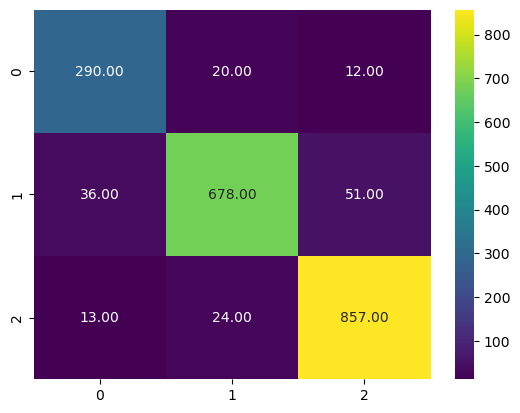

In [33]:
fine_pred_prob = resnet_finetuned.predict(X_val)
fine_y_pred = np.argmax(fine_pred_prob, axis=1)

resnet_conf_matrix = confusion_matrix(y_true, fine_y_pred)
sns.heatmap(resnet_conf_matrix, annot=True, fmt=".2f", cmap='viridis')
plt.show()

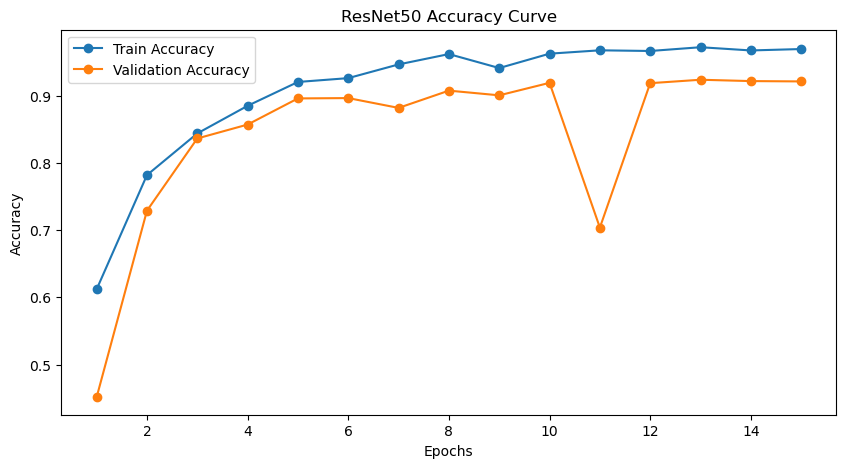

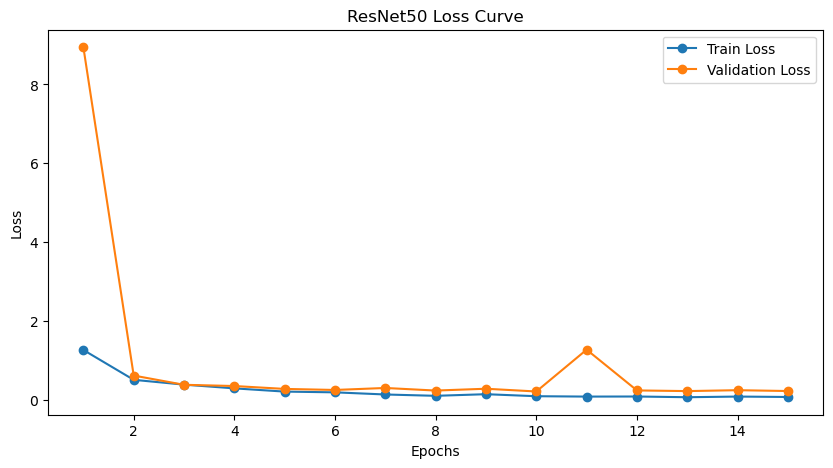

In [7]:
epochs = list(range(1, 16))

# Training and validation loss values from verbose output
train_loss = [1.2707, 0.5145, 0.3925, 0.2978, 0.2160, 0.1971, 0.1428, 0.1091, 0.1501, 0.0991, 
              0.0896, 0.0917, 0.0735, 0.0902, 0.0795]
val_loss = [8.9433, 0.6225, 0.3885, 0.3572, 0.2840, 0.2575, 0.3079, 0.2424, 0.2885, 0.2187, 
            1.2786, 0.2457, 0.2288, 0.2517, 0.2304]

# Training and validation accuracy values from verbose output
train_accuracy = [0.6119, 0.7819, 0.8439, 0.8850, 0.9205, 0.9262, 0.9466, 0.9620, 0.9412, 0.9626, 
                  0.9676, 0.9666, 0.9722, 0.9674, 0.9695]
val_accuracy = [0.4513, 0.7289, 0.8364, 0.8571, 0.8960, 0.8965, 0.8819, 0.9076, 0.9006, 0.9192, 
                0.7037, 0.9187, 0.9238, 0.9218, 0.9213]

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNet50 Accuracy Curve')
plt.savefig("ResNet Accuracy Curve.png", dpi=300)
plt.show()

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet50 Loss Curve')
plt.savefig("ResNet Loss Curve.png", dpi=300)
plt.show()


In [46]:
results = []
r_precision, r_recall, r_f1, _ = precision_recall_fscore_support(y_true, fine_y_pred, average='weighted')
resnet_accuracy = accuracy_score(y_true, fine_y_pred, )
results.append(["ResNet50", 
                f"{resnet_accuracy*100:.3f}%", 
                f"{r_precision*100:.3f}%", 
                f"{r_recall*100:.3f}%", 
                f"{r_f1*100:.3f}%"])

In [53]:
model.save("finetuned_resnet.h5")

# DenseNet121

In [10]:
base_densenet = DenseNet121(weights="imagenet", include_top=False, input_shape=(X_flat.shape[1], X_flat.shape[2], 3))

base_densenet.trainable = False  

# Add Custom Classifier on top
y = base_densenet.output
y = GlobalAveragePooling2D()(y)  # Global Average Pooling
y = Dense(256, activation='relu')(y)  # Fully Connected Layer
y = Dropout(0.5)(y)  # Dropout for regularization
output_layer = Dense(3, activation='softmax')(y)# Output Layer (3 classes)

dense_model = Model(inputs=base_densenet.input, outputs=output_layer)

dense_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [11]:
densenet_history = dense_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=15, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/15
248/248 [==============================] - 549s 2s/step - loss: 1.3457 - accuracy: 0.3942 - val_loss: 0.9918 - val_accuracy: 0.5098 - lr: 1.0000e-05
Epoch 2/15
248/248 [==============================] - 556s 2s/step - loss: 1.1371 - accuracy: 0.4743 - val_loss: 0.9217 - val_accuracy: 0.5356 - lr: 1.0000e-05
Epoch 3/15
248/248 [==============================] - 548s 2s/step - loss: 1.0526 - accuracy: 0.4955 - val_loss: 0.8811 - val_accuracy: 0.5558 - lr: 1.0000e-05
Epoch 4/15
248/248 [==============================] - 551s 2s/step - loss: 0.9714 - accuracy: 0.5309 - val_loss: 0.8572 - val_accuracy: 0.5785 - lr: 1.0000e-05
Epoch 5/15
248/248 [==============================] - 541s 2s/step - loss: 0.9250 - accuracy: 0.5431 - val_loss: 0.8407 - val_accuracy: 0.5921 - lr: 1.0000e-05
Epoch 6/15
248/248 [==============================] - 477s 2s/step - loss: 0.8950 - accuracy: 0.5632 - val_loss: 0.8255 - val_accuracy: 0.6017 - lr: 1.0000e-05
Epoch 7/15
248/248 [====================

In [12]:
densenet_loss, densenet_accuracy = dense_model.evaluate(X_val, y_val)
print(f"Loss - {densenet_loss}\nAccuracy - {densenet_accuracy}")

62/62 [==============================] - 81s 1s/step - loss: 0.7601 - accuracy: 0.6421
Loss - 0.76014244556427
Accuracy - 0.6420999765396118


In [13]:
dense_pred_prob = dense_model.predict(X_val)
dense_y_pred = np.argmax(dense_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

print(f"Classification Report\n {classification_report(y_true, dense_y_pred)}")
print(f"\nConfusion Matrix\n {confusion_matrix(y_true, dense_y_pred)}")

62/62 [==============================] - 87s 1s/step
Classification Report
               precision    recall  f1-score   support

           0       0.60      0.21      0.32       322
           1       0.56      0.73      0.64       765
           2       0.74      0.72      0.73       894

    accuracy                           0.64      1981
   macro avg       0.63      0.56      0.56      1981
weighted avg       0.65      0.64      0.63      1981


Confusion Matrix
 [[ 69 202  51]
 [ 32 562 171]
 [ 14 239 641]]


# DenseNet121 - FineTuned

In [14]:
base_densenet.trainable = True
for layer in base_densenet.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

In [15]:
dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
dense_fine_history = dense_model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=15,
          batch_size=32,
          class_weight=class_weights_dict,
          callbacks=[early_stopping, reduce_lr])

Epoch 1/15
248/248 [==============================] - 1485s 6s/step - loss: 0.9904 - accuracy: 0.5748 - val_loss: 0.6957 - val_accuracy: 0.6810 - lr: 1.0000e-05
Epoch 2/15
248/248 [==============================] - 1649s 7s/step - loss: 0.6659 - accuracy: 0.6843 - val_loss: 0.6045 - val_accuracy: 0.7188 - lr: 1.0000e-05
Epoch 3/15
248/248 [==============================] - 1054s 4s/step - loss: 0.5399 - accuracy: 0.7615 - val_loss: 0.5598 - val_accuracy: 0.7400 - lr: 1.0000e-05
Epoch 4/15
248/248 [==============================] - 840s 3s/step - loss: 0.4348 - accuracy: 0.8150 - val_loss: 0.4747 - val_accuracy: 0.7940 - lr: 1.0000e-05
Epoch 5/15
248/248 [==============================] - 830s 3s/step - loss: 0.3357 - accuracy: 0.8660 - val_loss: 0.4386 - val_accuracy: 0.8193 - lr: 1.0000e-05
Epoch 6/15
248/248 [==============================] - 1114s 4s/step - loss: 0.2506 - accuracy: 0.9040 - val_loss: 0.3578 - val_accuracy: 0.8597 - lr: 1.0000e-05
Epoch 7/15
248/248 [================

In [19]:
fine_densenet_loss, fine_densenet_accuracy = dense_model.evaluate(X_val, y_val)
print(f"Loss - {fine_densenet_loss}\nAccuracy - {fine_densenet_accuracy}")

62/62 [==============================] - 133s 2s/step - loss: 0.2691 - accuracy: 0.9132
Loss - 0.2691313326358795
Accuracy - 0.9131751656532288


In [20]:
dense_fine_pred_prob = dense_model.predict(X_val)
dense_fine_y_pred = np.argmax(dense_fine_pred_prob, axis=1)

print(f"Classification Report\n {classification_report(y_true, dense_fine_y_pred)}")
print(f"\nConfusion Matrix\n {confusion_matrix(y_true, dense_fine_y_pred)}")

62/62 [==============================] - 143s 2s/step
Classification Report
               precision    recall  f1-score   support

           0       0.86      0.89      0.88       322
           1       0.89      0.90      0.89       765
           2       0.95      0.93      0.94       894

    accuracy                           0.91      1981
   macro avg       0.90      0.91      0.90      1981
weighted avg       0.91      0.91      0.91      1981


Confusion Matrix
 [[288  29   5]
 [ 42 686  37]
 [  5  54 835]]


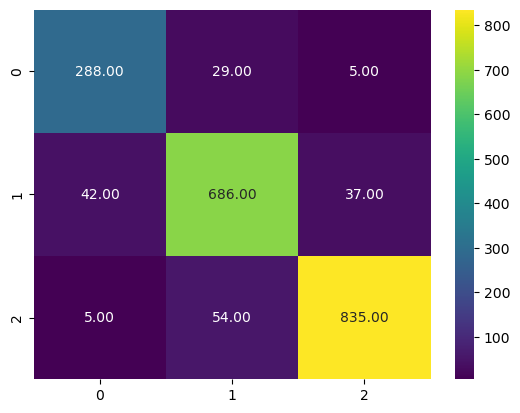

In [29]:
dense_conf_matrix = confusion_matrix(y_true, dense_fine_y_pred)
sns.heatmap(dense_conf_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.show()

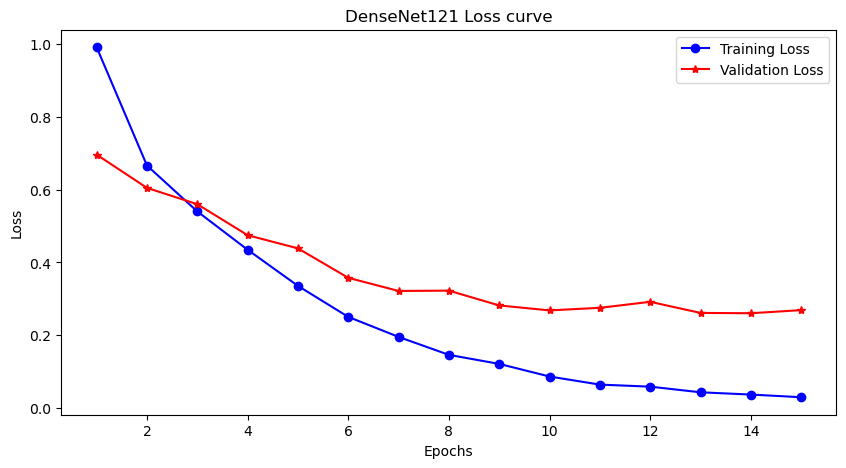

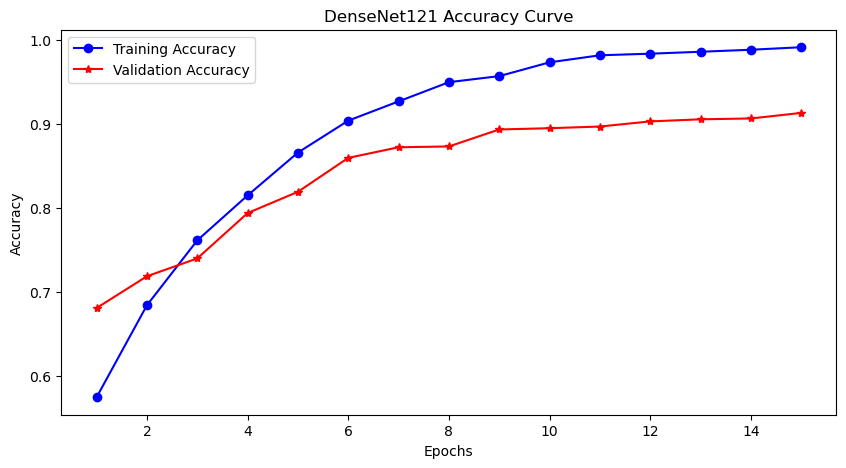

In [10]:
dense_epochs = list(range(1, 16))

# Extracted accuracy and loss values
dense_train_loss = [0.9904, 0.6659, 0.5399, 0.4348, 0.3357, 0.2506, 0.1957, 0.1464, 0.1216, 0.0870, 0.0648, 0.0592, 0.0437, 0.0375, 0.0302]
dense_val_loss = [0.6957, 0.6045, 0.5598, 0.4747, 0.4386, 0.3578, 0.3217, 0.3226, 0.2820, 0.2684, 0.2755, 0.2919, 0.2615, 0.2606, 0.2691]
dense_train_acc = [0.5748, 0.6843, 0.7615, 0.8150, 0.8660, 0.9040, 0.9269, 0.9498, 0.9570, 0.9734, 0.9818, 0.9837, 0.9860, 0.9884, 0.9914]
dense_val_acc = [0.6810, 0.7188, 0.7400, 0.7940, 0.8193, 0.8597, 0.8723, 0.8733, 0.8935, 0.8950, 0.8970, 0.9031, 0.9056, 0.9066, 0.9132]

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(dense_epochs, dense_train_loss, 'bo-', label='Training Loss')
plt.plot(dense_epochs, dense_val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('DenseNet121 Loss curve')
plt.legend()
plt.savefig("Dense Loss.png", dpi=300)
plt.show()


# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(dense_epochs, dense_train_acc, 'bo-', label='Training Accuracy')
plt.plot(dense_epochs, dense_val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('DenseNet121 Accuracy Curve')
plt.legend()
plt.savefig("Dense Accuracy.png", dpi=300)
plt.show()


In [48]:
d_precision, d_recall, d_f1, _ = precision_recall_fscore_support(y_true, dense_fine_y_pred, average='weighted')
densenet_accuracy = accuracy_score(y_true, dense_fine_y_pred, )
results.append(["DenseNet121", 
                f"{densenet_accuracy*100:.3f}%", 
                f"{d_precision*100:.3f}%", 
                f"{d_recall*100:.3f}%", 
                f"{d_f1*100:.3f}%"])

In [21]:
dense_model.save("finetuned_densenet.h5")

# Results

In [54]:
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F-Score']

with open("Models_Results.csv", 'w', newline='') as file:
    csvWriter = csv.writer(file)
    csvWriter.writerow(headers)
    csvWriter.writerows(results)

In [66]:
print(tabulate(results, headers=headers, tablefmt='pretty'))

+-------------+----------+-----------+---------+---------+
|    Model    | Accuracy | Precision | Recall  | F-Score |
+-------------+----------+-----------+---------+---------+
|  ResNet50   | 92.125%  |  92.207%  | 92.125% | 92.118% |
| DenseNet121 | 91.318%  |  91.390%  | 91.318% | 91.344% |
+-------------+----------+-----------+---------+---------+


---

# Vision Transformers

In [8]:
class_labels = np.argmax(y_train, axis=1)  # Convert one-hot to integer labels

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 2.0552529182879375, 1: 0.8733465608465608, 2: 0.7307692307692307}


In [9]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    do_rescale=False  # Important: since your images are already normalized
)

# Hugging Face ViT expects inputs shaped as dictionary with pixel values
def preprocess_for_vit_batch(images, batch_size=32):
    pixel_values_list = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        processed = feature_extractor(images=list(batch), return_tensors="tf")['pixel_values']
        pixel_values_list.append(processed)
    return tf.concat(pixel_values_list, axis=0)


In [10]:
X_train_vit = preprocess_for_vit_batch(X_train)
X_val_vit = preprocess_for_vit_batch(X_val)

In [11]:
vit_base = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [12]:
vit_base.trainable = False  # Freeze base

# Input matches preprocessed shape: (3, 224, 224)
input_layer = Input(shape=(3, 224, 224), name='vit_input')

# Wrap the ViT model inside a Lambda to make it compatible with Keras Functional API
vit_features = Lambda(lambda pixel_values: vit_base(pixel_values).last_hidden_state)(input_layer)

# Add pooling and classification head
x = GlobalAveragePooling1D()(vit_features)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)

# Final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vit_input (InputLayer)               │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 197, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 768)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           2,307 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
vit_history = model.fit(X_train_vit, 
                        y_train, 
                        validation_data=(X_val_vit, y_val), 
                        epochs=10,
                        callbacks=[early_stopping],
                        class_weight=class_weights_dict,
                        batch_size=32)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2587s 10s/step - accuracy: 0.4781 - loss: 1.0090 - val_accuracy: 0.5775 - val_loss: 0.8816
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2601s 10s/step - accuracy: 0.6043 - loss: 0.8401 - val_accuracy: 0.6280 - val_loss: 0.8102
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2620s 11s/step - accuracy: 0.6203 - loss: 0.7991 - val_accuracy: 0.6577 - val_loss: 0.7626
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2597s 10s/step - accuracy: 0.6419 - loss: 0.7617 - val_accuracy: 0.6471 - val_loss: 0.7665
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2797s 11s/step - accuracy: 0.6437 - loss: 0.7478 - val_accuracy: 0.6603 - val_loss: 0.7357
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2755s 11s/step - accuracy: 0.6624 - loss: 0.7294 - val_accuracy: 0.6709 - val_loss: 0.7250
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3013s 12s/step - accuracy: 0.6674 - loss: 0.7265 - val_accuracy: 0.6689 - val_loss: 0.7301
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2580s 10s/step - accuracy: 0.6679 - loss: 0

In [15]:
model.save("vit.h5")

# ViT Finetuned

In [16]:
vit_base.trainable = True

In [17]:
model.compile(
    optimizer='adam',  # or 3e-5 / 5e-6
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [19]:
vit_finetune_history = model.fit(
    X_train_vit,
    y_train,
    validation_data=(X_val_vit, y_val),
    epochs=10,  # Try 3–10 more epochs based on validation loss
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2637s 11s/step - accuracy: 0.6754 - loss: 0.7067 - val_accuracy: 0.6588 - val_loss: 0.7282
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2620s 11s/step - accuracy: 0.6774 - loss: 0.7035 - val_accuracy: 0.6613 - val_loss: 0.7205
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2610s 11s/step - accuracy: 0.6757 - loss: 0.7006 - val_accuracy: 0.6926 - val_loss: 0.6834
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2605s 11s/step - accuracy: 0.6809 - loss: 0.6904 - val_accuracy: 0.7012 - val_loss: 0.6671
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2589s 10s/step - accuracy: 0.6743 - loss: 0.7029 - val_accuracy: 0.6901 - val_loss: 0.6781
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2624s 11s/step - accuracy: 0.6818 - loss: 0.6882 - val_accuracy: 0.6850 - val_loss: 0.6892
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2597s 10s/step - accuracy: 0.6837 - loss: 0.6831 - val_accuracy: 0.6855 - val_loss: 0.6903


In [20]:
val_loss, val_acc = model.evaluate(X_val_vit, y_val)
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 513s 8s/step - accuracy: 0.7199 - loss: 0.6531
Validation Accuracy: 0.7012, Loss: 0.6671


In [21]:
y_pred_probs = model.predict(X_val_vit)
y_pred = np.argmax(y_pred_probs, axis=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 517s 8s/step


In [22]:
# Convert one-hot to class labels if necessary
if y_val.ndim > 1 and y_val.shape[1] > 1:
    y_val_labels = np.argmax(y_val, axis=1)
else:
    y_val_labels = y_val

In [23]:
print(classification_report(y_val_labels, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.62      0.58       322
           1       0.63      0.75      0.68       765
           2       0.88      0.69      0.77       894

    accuracy                           0.70      1981
   macro avg       0.68      0.69      0.68      1981
weighted avg       0.73      0.70      0.71      1981



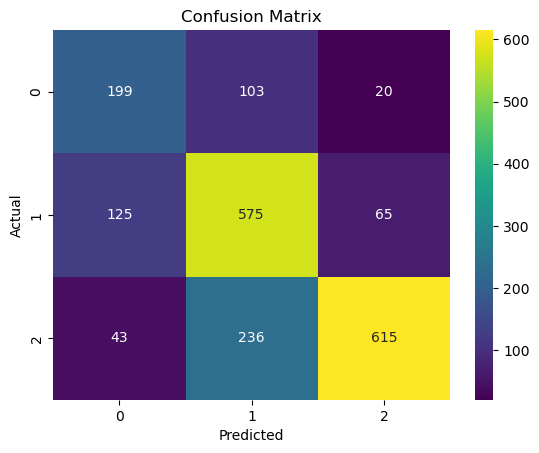

In [24]:
cm = confusion_matrix(y_val_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

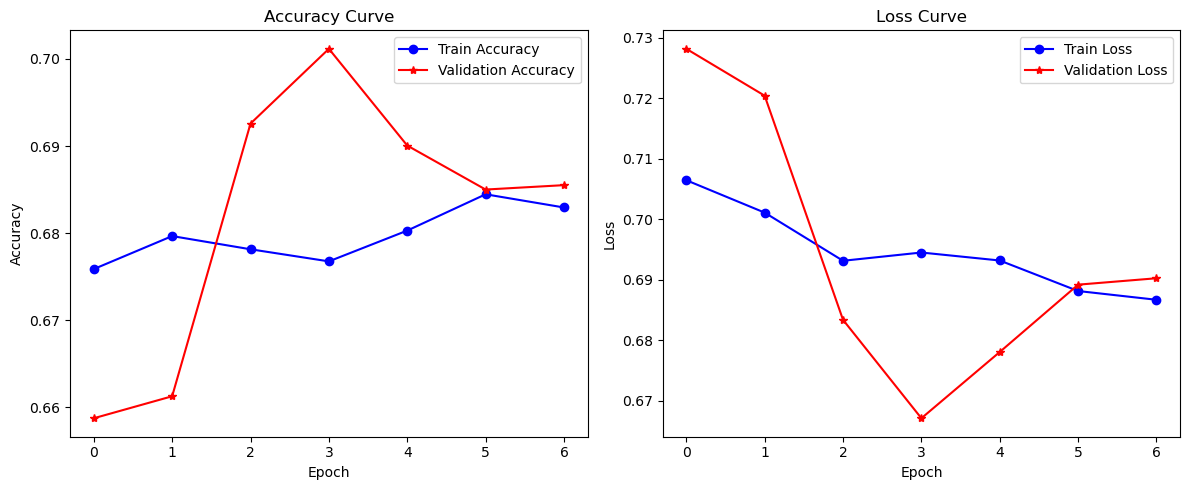

In [25]:
# Accuracy plot
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(vit_finetune_history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(vit_finetune_history.history['val_accuracy'], 'r*-', label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(vit_finetune_history.history['loss'], 'bo-', label='Train Loss')
plt.plot(vit_finetune_history.history['val_loss'], 'r*-', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
model.save("finetuned_vit.h5")

In [34]:
model.compile(optimizer=Adam(learning_rate=3e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
vit_finetune_history = model.fit(
    X_train_vit,
    y_train,
    validation_data=(X_val_vit, y_val),
    epochs=5,  # Try 3–10 more epochs based on validation loss
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 2614s 10s/step - accuracy: 0.6971 - loss: 0.6560 - val_accuracy: 0.7108 - val_loss: 0.6531 - learning_rate: 3.0000e-05
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 2641s 11s/step - accuracy: 0.6947 - loss: 0.6639 - val_accuracy: 0.7108 - val_loss: 0.6530 - learning_rate: 3.0000e-05
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 2908s 12s/step - accuracy: 0.6974 - loss: 0.6687 - val_accuracy: 0.7102 - val_loss: 0.6529 - learning_rate: 3.0000e-05
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 3073s 12s/step - accuracy: 0.7001 - loss: 0.6530 - val_accuracy: 0.7097 - val_loss: 0.6526 - learning_rate: 3.0000e-05
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 3684s 15s/step - accuracy: 0.6964 - loss: 0.6647 - val_accuracy: 0.7097 - val_loss: 0.6525 - learning_rate: 3.0000e-05


In [37]:
val_loss, val_acc = model.evaluate(X_val_vit, y_val)
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 626s 10s/step - accuracy: 0.7135 - loss: 0.6314 
Validation Accuracy: 0.7097, Loss: 0.6525


In [38]:
print(classification_report(y_val_labels, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.41      0.49       322
           1       0.64      0.75      0.69       765
           2       0.81      0.79      0.80       894

    accuracy                           0.71      1981
   macro avg       0.68      0.65      0.66      1981
weighted avg       0.71      0.71      0.70      1981



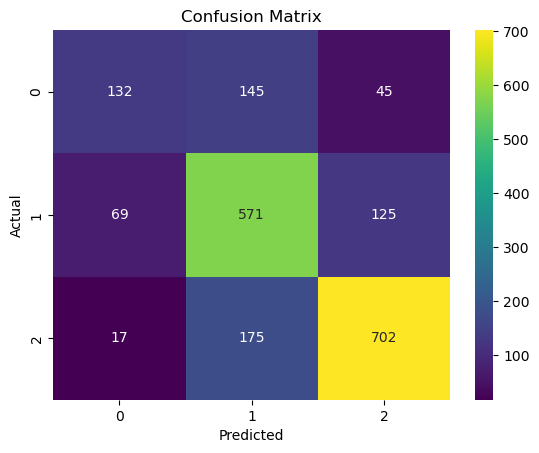

In [39]:
cm = confusion_matrix(y_val_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

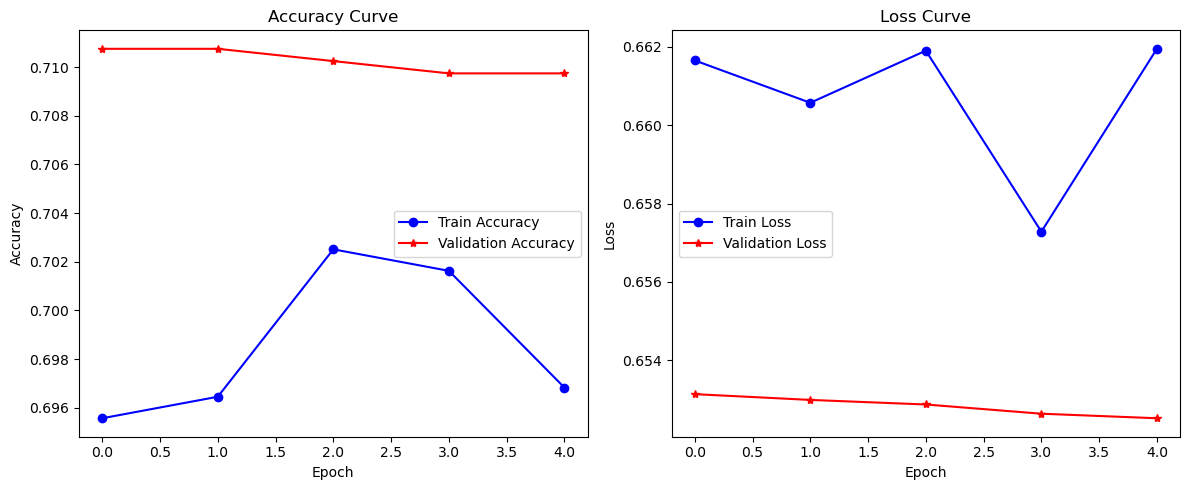

In [40]:
# Accuracy plot
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(vit_finetune_history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(vit_finetune_history.history['val_accuracy'], 'r*-', label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(vit_finetune_history.history['loss'], 'bo-', label='Train Loss')
plt.plot(vit_finetune_history.history['val_loss'], 'r*-', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
# Use a hybrid model just like used in research - probably CNN + ViT
# Use code till X and y, after that start from here

# EfficientNet

In [8]:
num_classes = 3

In [9]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze for feature extraction

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.4389 - loss: 1.0501 - val_accuracy: 0.4513 - val_loss: 1.0224 - learning_rate: 0.0010
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.4327 - loss: 1.0489 - val_accuracy: 0.4513 - val_loss: 1.0241 - learning_rate: 0.0010
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.4205 - loss: 1.0438 - val_accuracy: 0.4513 - val_loss: 1.0224 - learning_rate: 0.0010
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.4218 - loss: 1.0357 - val_accuracy: 0.4513 - val_loss: 1.0234 - learning_rate: 5.0000e-04
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.4305 - loss: 1.0326 - val_accuracy: 0.3862 - val_loss: 1.0270 - learning_rate: 5.0000e-04
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.4363 - loss: 1.0361 - val_accuracy: 0.4513 - val_loss: 1.0231 - learning_rate: 2.5000e-04


In [13]:
model.save("efficientnet.keras")

# EfficientNet Finetuning

In [11]:
class_labels = np.argmax(y_train, axis=1)  # Convert one-hot to integer labels

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 2.0552529182879375, 1: 0.8733465608465608, 2: 0.7307692307692307}


In [12]:
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
finetune_history = model.fit(X_train,
                             y_train,
                             validation_data=(X_val, y_val),
                             epochs=20,
                             class_weight=class_weights_dict,
                             callbacks=[early_stopping, reduce_lr],
                             batch_size=32)

Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.2932 - loss: 1.1336 - val_accuracy: 0.1661 - val_loss: 1.1159 - learning_rate: 1.0000e-05
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.4281 - loss: 1.0517 - val_accuracy: 0.1812 - val_loss: 1.2228 - learning_rate: 1.0000e-05
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.4911 - loss: 0.9886 - val_accuracy: 0.3246 - val_loss: 1.1724 - learning_rate: 1.0000e-05
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.5083 - loss: 0.9600 - val_accuracy: 0.3423 - val_loss: 1.1750 - learning_rate: 5.0000e-06


In [17]:
model.save("finetuned_efficientnet.keras")

# Xception

In [25]:
X_train_resized = tf.image.resize(X_train, [299, 299]).numpy()
X_val_resized = tf.image.resize(X_val, [299, 299]).numpy()

In [27]:
from tensorflow.keras import backend as K
K.clear_session()

base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # Assuming 3 classes

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [28]:
history = model.fit(X_train_resized, y_train, validation_data=(X_val_resized, y_val),
                    epochs=20, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1180s 5s/step - accuracy: 0.4247 - loss: 1.0570 - val_accuracy: 0.5442 - val_loss: 0.9378 - learning_rate: 1.0000e-04
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1129s 5s/step - accuracy: 0.5375 - loss: 0.9408 - val_accuracy: 0.5785 - val_loss: 0.8902 - learning_rate: 1.0000e-04
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1130s 5s/step - accuracy: 0.5509 - loss: 0.9032 - val_accuracy: 0.5906 - val_loss: 0.8613 - learning_rate: 1.0000e-04
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1131s 5s/step - accuracy: 0.5832 - loss: 0.8686 - val_accuracy: 0.5992 - val_loss: 0.8406 - learning_rate: 1.0000e-04
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1128s 5s/step - accuracy: 0.5883 - loss: 0.8490 - val_accuracy: 0.6108 - val_loss: 0.8241 - learning_rate: 1.0000e-04
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1131s 5s/step - accuracy: 0.6049 - loss: 0.8275 - val_accuracy: 0.6138 - val_loss: 0.8112 - learning_rate: 1.0000e-04
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1122s 5s/ste

In [29]:
model.save("xception.keras")

In [31]:
y_pred_prob = model.predict(X_val_resized)
y_pred = np.argmax(y_pred_prob, axis=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step


In [33]:
y_true = np.argmax(y_val, axis=1)

In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.34      0.43       322
           1       0.61      0.69      0.64       765
           2       0.74      0.77      0.75       894

    accuracy                           0.67      1981
   macro avg       0.64      0.60      0.61      1981
weighted avg       0.66      0.67      0.66      1981



# Xception Finetuned

In [14]:
model = load_model("xception.keras")

In [15]:
class_labels = np.argmax(y_train, axis=1)  # Convert one-hot to integer labels

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 2.0552529182879375, 1: 0.8733465608465608, 2: 0.7307692307692307}


In [22]:
# Set layer trainability - unfreeze from block11 onward (optional fine-tuning strategy)
set_trainable = False
for layer in model.layers:
    if layer.name == 'block11_sepconv1':  # start unfreezing from here
        set_trainable = True
    layer.trainable = set_trainable

# Extract output from final convolutional layer
x = model.get_layer("block13_sepconv2_bn").output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation="softmax")(x)  # change num_classes

# Create new model
finetune_model = Model(inputs=model.input, outputs=output)

In [23]:
finetune_model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
finetune_history = finetune_model.fit(X_train_resized,
                             y_train,
                             validation_data=(X_val_resized, y_val),
                             epochs=20,
                             callbacks=[early_stopping, reduce_lr],
                             class_weight=class_weights_dict,
                             batch_size=32)

Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1892s 7s/step - accuracy: 0.4382 - loss: 1.0760 - val_accuracy: 0.6063 - val_loss: 0.8719 - learning_rate: 1.0000e-05
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1844s 7s/step - accuracy: 0.6056 - loss: 0.8565 - val_accuracy: 0.6583 - val_loss: 0.7562 - learning_rate: 1.0000e-05
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1794s 7s/step - accuracy: 0.6602 - loss: 0.7213 - val_accuracy: 0.6961 - val_loss: 0.6827 - learning_rate: 1.0000e-05
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1806s 7s/step - accuracy: 0.6945 - loss: 0.6514 - val_accuracy: 0.7284 - val_loss: 0.6145 - learning_rate: 1.0000e-05
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1806s 7s/step - accuracy: 0.7417 - loss: 0.5632 - val_accuracy: 0.7496 - val_loss: 0.5710 - learning_rate: 1.0000e-05
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1806s 7s/step - accuracy: 0.7650 - loss: 0.5098 - val_accuracy: 0.7834 - val_loss: 0.5150 - learning_rate: 1.0000e-05
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 2107s 9s/ste

In [27]:
finetune_model.save("finetuned_xception.keras")

In [28]:
y_true = np.argmax(y_val, axis=1)
y_pred_prob = finetune_model.predict(X_val_resized)
y_pred = np.argmax(y_pred_prob, axis=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step


In [29]:
print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

0.9030792529025744
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       322
           1       0.91      0.86      0.89       765
           2       0.94      0.93      0.94       894

    accuracy                           0.90      1981
   macro avg       0.88      0.90      0.89      1981
weighted avg       0.91      0.90      0.90      1981



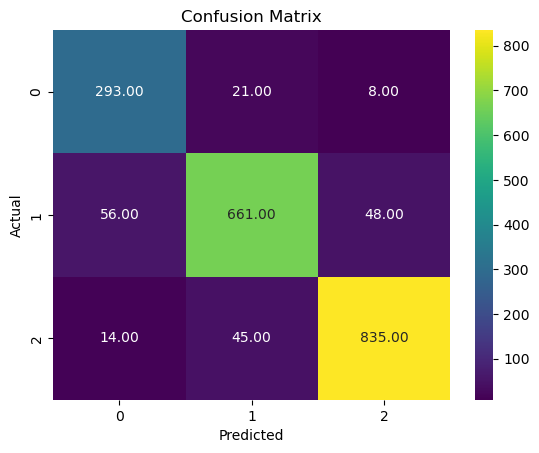

In [30]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

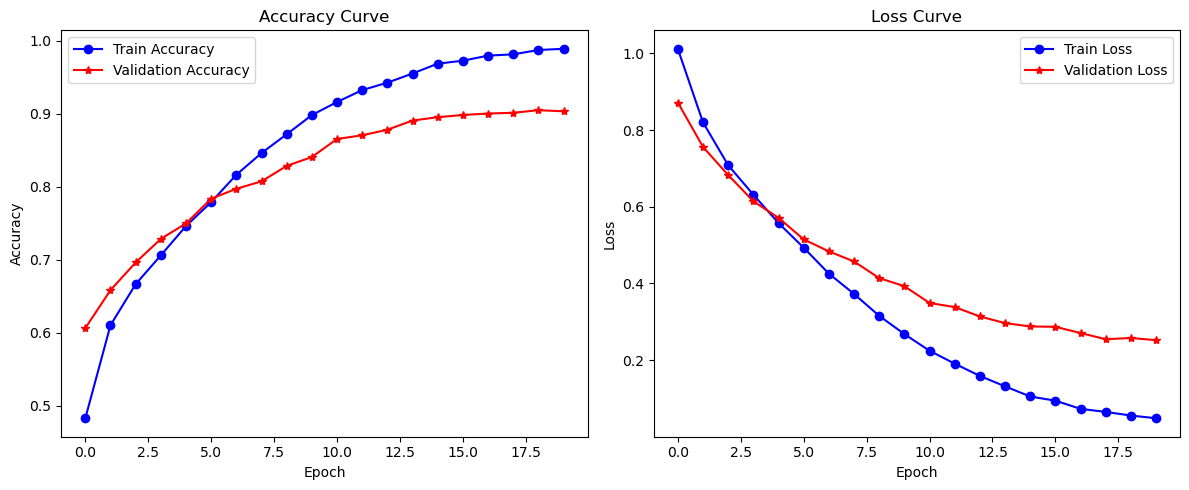

In [31]:
# Accuracy plot
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(finetune_history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(finetune_history.history['val_accuracy'], 'r*-', label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(finetune_history.history['loss'], 'bo-', label='Train Loss')
plt.plot(finetune_history.history['val_loss'], 'r*-', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
loss, accuracy = finetune_model.evaluate(X_val_resized, y_val)
print(f"Loss - {loss}\nAccuracy - {accuracy}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.9104 - loss: 0.2424
Loss - 0.25195440649986267
Accuracy - 0.9030792713165283


# EfficientNetB3

In [10]:
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'  # GlobalAveragePooling2D
)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 25s 1us/step


In [13]:
# Freeze base model
base_model.trainable = False

# Build the full model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',  # or 'binary_crossentropy' for binary class
    metrics=['accuracy']
)

In [18]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=5,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr],
                    batch_size=32)

Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 534s 2s/step - accuracy: 0.3570 - loss: 1.1147 - val_accuracy: 0.4382 - val_loss: 1.0433 - learning_rate: 0.0010
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.3575 - loss: 1.1104 - val_accuracy: 0.4427 - val_loss: 1.0771 - learning_rate: 0.0010
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.3466 - loss: 1.1211 - val_accuracy: 0.4876 - val_loss: 1.0547 - learning_rate: 0.0010
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.3914 - loss: 1.0921 - val_accuracy: 0.3715 - val_loss: 1.0831 - learning_rate: 5.0000e-04
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.3450 - loss: 1.1151 - val_accuracy: 0.2166 - val_loss: 1.1362 - learning_rate: 5.0000e-04


# EfficientNetB3 Finetuning

In [20]:
base_model.trainable = True

# Freeze all layers except the top N
fine_tune_at = len(base_model.layers) - 100  # fine-tune top 100 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
finetune_history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=15,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr],
                    batch_size=32)

Epoch 1/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 786s 3s/step - accuracy: 0.3655 - loss: 1.1261 - val_accuracy: 0.4180 - val_loss: 1.0379 - learning_rate: 1.0000e-05
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 744s 3s/step - accuracy: 0.3884 - loss: 1.0874 - val_accuracy: 0.4109 - val_loss: 1.0585 - learning_rate: 1.0000e-05
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 739s 3s/step - accuracy: 0.4064 - loss: 1.0845 - val_accuracy: 0.3720 - val_loss: 1.1514 - learning_rate: 1.0000e-05
Epoch 4/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 732s 3s/step - accuracy: 0.4147 - loss: 1.0743 - val_accuracy: 0.4094 - val_loss: 1.1011 - learning_rate: 5.0000e-06
Epoch 5/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 732s 3s/step - accuracy: 0.4266 - loss: 1.0554 - val_accuracy: 0.4609 - val_loss: 1.0401 - learning_rate: 5.0000e-06
Epoch 6/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 739s 3s/step - accuracy: 0.4278 - loss: 1.0501 - val_accuracy: 0.4750 - val_loss: 1.0202 - learning_rate: 2.5000e-06
Epoch 7/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 739s 3s/step - acc

In [24]:
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step


In [25]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.16      0.22       322
           1       0.42      0.78      0.55       765
           2       0.70      0.33      0.45       894

    accuracy                           0.48      1981
   macro avg       0.49      0.42      0.40      1981
weighted avg       0.54      0.48      0.45      1981



# ConvNeXtTiny

In [32]:
# Input shape
input_shape = (224, 224, 3)
num_classes = 3  # update this if different

# Load ConvNeXtTiny without top
base_model = ConvNeXtTiny(weights="imagenet", include_top=False, input_shape=input_shape)

# Freeze all layers initially
base_model.trainable = False

# Custom classification head
inputs = Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax")(x)
model = Model(inputs, outputs)


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 61s 1us/step 


In [33]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])


In [34]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3620s 14s/step - accuracy: 0.4164 - loss: 1.1674 - val_accuracy: 0.4649 - val_loss: 0.9683 - learning_rate: 0.0010
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3434s 14s/step - accuracy: 0.5173 - loss: 0.9719 - val_accuracy: 0.5704 - val_loss: 0.9256 - learning_rate: 0.0010
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3423s 14s/step - accuracy: 0.5591 - loss: 0.9292 - val_accuracy: 0.5659 - val_loss: 0.9080 - learning_rate: 0.0010
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3406s 14s/step - accuracy: 0.5575 - loss: 0.9090 - val_accuracy: 0.5618 - val_loss: 0.8962 - learning_rate: 0.0010
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3404s 14s/step - accuracy: 0.5695 - loss: 0.9040 - val_accuracy: 0.5613 - val_loss: 0.8881 - learning_rate: 0.0010
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3432s 14s/step - accuracy: 0.5646 - loss: 0.8867 - val_accuracy: 0.5946 - val_loss: 0.8748 - learning_rate: 0.0010
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3409s 14s/step - accuracy: 0.5

In [36]:
model.save("convnexttiny.keras")

In [37]:
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 679s 11s/step 


In [38]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.02      0.04       322
           1       0.54      0.62      0.58       765
           2       0.63      0.78      0.70       894

    accuracy                           0.59      1981
   macro avg       0.60      0.47      0.44      1981
weighted avg       0.60      0.59      0.54      1981



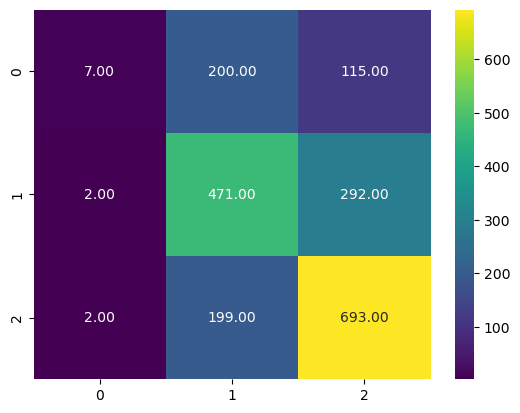

<Figure size 1000x500 with 0 Axes>

In [41]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='.2f', cmap='viridis')
plt.figure(figsize=(10, 5))
plt.show()